In [1]:
import collections
import os
import json
import logging

import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA
from rna_learn.load_sequences import (
    load_growth_temperatures, 
    compute_inverse_effective_sample,
    assign_weight_to_batch_values,
    SpeciesSequence,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model, DenormalizedMAE

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
run_id = 'run_regj7'
model_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/model.h5')
metadata_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/metadata.json')

In [5]:
with open(metadata_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_regj7',
 'alphabet': ['A', 'C', 'G', 'T'],
 'learning_rate': 0.0005,
 'batch_size': 64,
 'encoding_size': 20,
 'decoder_n_hidden': 100,
 'growth_rate': 15,
 'n_layers': 10,
 'kernel_sizes': [3, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'strides': None,
 'dilation_rates': None,
 'l2_reg': 1e-05,
 'dropout': 0.5,
 'n_epochs': 2,
 'max_sequence_length': 5000,
 'seed': 3943,
 'val_loss': 1.5735052824020386}

In [6]:
model = conv1d_densenet_regression_model(
    alphabet_size=len(metadata['alphabet']), 
    growth_rate=metadata['growth_rate'],
    n_layers=metadata['n_layers'],
    kernel_sizes=metadata['kernel_sizes'],
    dilation_rates=metadata['dilation_rates'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 15)     195         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 19)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 15)     1440        concat_1[0][0]        

## Load sequences from a single specie

In [7]:
query = """
select t.species, s.sequence, s.length, t.growth_tmp
from sequences as s
inner join species_traits as t
on t.species_taxid = s.species_taxid
where s.species_taxid = ?
"""
species_taxid = 14
species_df = pd.read_sql(query, engine, params=(species_taxid,))
len(species_df)

2641

In [8]:
species = species_df['species'].iloc[0]
actual_tmp = species_df['growth_tmp'].iloc[0]
species, actual_tmp

('Dictyoglomus thermophilum', 74.15)

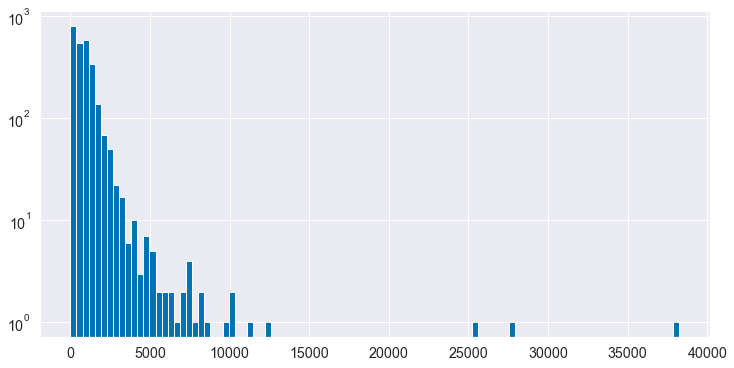

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(species_df['length'], bins=100, log=True);

In [10]:
actual_tmp = species_df['growth_tmp'].iloc[0]
actual_tmp

74.15

In [11]:
temperatures, mean, std = load_growth_temperatures(engine)

In [12]:
max_sequence_length = metadata.get('max_sequence_length', 5000)
species_seq = SpeciesSequence(
    engine, 
    species_taxid=species_taxid,
    batch_size=64, 
    temperatures=temperatures,
    mean=mean,
    std=std,
    alphabet=ALPHABET_DNA, 
    max_sequence_length=max_sequence_length,
    random_seed=444,
)

In [13]:
compile_regression_model(
    model, 
    learning_rate=1e-4,
)
model.load_weights(model_path)

In [14]:
temperature_range = np.arange(-15, 125, 0.5)
temperature_range_norm = normalize(temperature_range, mean, std)

In [15]:
%%time
cursor = 0
n_sequences = len(species_seq.rowids)
predictions = np.zeros((n_sequences, 1))
log_probabilities = np.zeros((n_sequences, len(temperature_range)))
for i in range(len(species_seq)):
    if (i + 1) % 10 == 0:
        print(f'{i+1} / {len(species_seq)}')
        
    x_batch, _, _ = species_seq[i]
    
    a = cursor
    b = cursor + len(x_batch)
    
    dist = model(x_batch)
    y_pred_norm = dist.mean().numpy()
    y_pred = denormalize(y_pred_norm, mean, std)
    predictions[a:b] = y_pred
    
    for j, t in enumerate(temperature_range_norm):
        log_probs = dist.log_prob(t).numpy()
        log_probabilities[a:b, j] = log_probs
        
    cursor += len(x_batch)

10 / 42
20 / 42
30 / 42
40 / 42
CPU times: user 31 s, sys: 19.8 s, total: 50.7 s
Wall time: 15.9 s


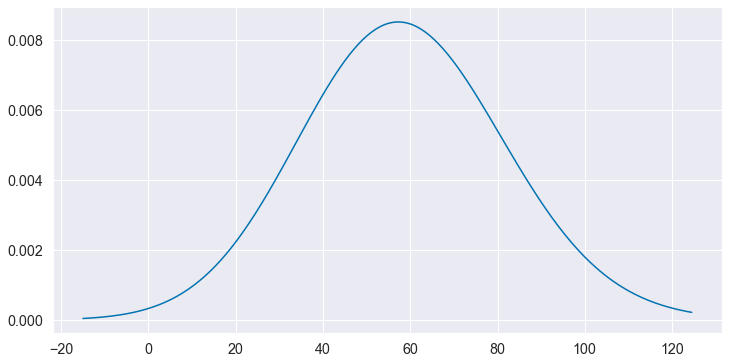

In [16]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
probs_u = np.exp(scipy.special.logsumexp(log_probabilities, axis=0))
probs = probs_u / np.sum(probs_u)
ax.plot(temperature_range, probs);

In [17]:
mode = temperature_range[np.argmax(probs)]
mean = np.average(temperature_range, weights=probs)

In [18]:
actual_tmp, mean, mode

(74.15, 58.33549184248362, 57.5)

In [19]:
variance = np.average(
    [(t - mean)**2 for t in temperature_range], 
    weights=probs,
)
std = np.sqrt(variance)
std

23.125909832859797